# 4.2.2 Network Similarity

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cosine
from scipy.stats import spearmanr, ttest_rel, mannwhitneyu
from collections import defaultdict
import glob
import os
import pickle

In [2]:
def calculate_trial_similarity(rest_trial_matrices, cond_trial_matrices):
    """
    Calculate trial-level network similarity metrics
    
    Parameters:
        rest_trial_matrices: List of all trial matrices for Rest condition
        cond_trial_matrices: List of all trial matrices for a given Condition
        
    Returns:
        list: List of dictionaries containing similarity metrics for each trial pair
    """
    similarity_results = []
    
    # Ensure equal number of trials
    n_trials = min(len(rest_trial_matrices), len(cond_trial_matrices))
    
    for i in range(n_trials):
        rest_mat = rest_trial_matrices[i]
        cond_mat = cond_trial_matrices[i]
        
        # Vectorize matrices (only upper triangle to avoid duplicate calculations for symmetric matrices)
        mask = np.triu_indices_from(rest_mat, k=1)
        rest_vec = rest_mat[mask]
        cond_vec = cond_mat[mask]
        
        # 1. Cosine similarity
        cos_sim = 1 - cosine(rest_vec, cond_vec)
        
        # 2. Spearman rank correlation
        rho, _ = spearmanr(rest_vec, cond_vec)
        
        # 3. Frobenius norm distance
        frob_dist = np.linalg.norm(rest_mat - cond_mat, 'fro')
        
        similarity_results.append({
            'cosine_similarity': cos_sim,
            'spearman_rho': rho,
            'frobenius_distance': frob_dist
        })
    
    return similarity_results

In [3]:
def load_network_data(results_folder='results', network_type='TE', atom_type='xty'):
    """
    Load network data and organize into structured dictionary
    
    Parameters:
        results_folder: Path containing .pkl result files
        network_type: Network type ('TE' or 'PhiID')
        atom_type: For PhiID networks, specify atom type
        
    Returns:
        dict: {
            'rest': {source: [matrix1, matrix2,...]},  # Rest condition data
            'conditions': {cond_name: {source: [matrix1, matrix2,...]}},  # Other condition data
            'roi_names': list,  # List of ROI names
            'metadata': {
                'network_type': str,
                'atom_type': str
            }
        }
    """
    result_files = glob.glob(os.path.join(results_folder, '*.pkl'))
    if not result_files:
        raise FileNotFoundError(f"No result files (.pkl) found in folder {results_folder}")
    
    data = {
        'rest': defaultdict(list),
        'conditions': defaultdict(lambda: defaultdict(list)),
        'roi_names': None,
        'metadata': {
            'network_type': network_type,
            'atom_type': atom_type
        }
    }
    
    for filepath in sorted(result_files):
        try:
            with open(filepath, 'rb') as f:
                results = pickle.load(f)
            
            # Get condition name
            cond = results.get('metadata', {}).get('selected_conditions', os.path.basename(filepath))
            if isinstance(cond, list):
                cond = cond[0] if len(cond) > 0 else os.path.basename(filepath)
            
            # Get ROI information
            if data['roi_names'] is None:
                data['roi_names'] = results['metadata']['roi_names']
                n_rois = len(data['roi_names'])
            
            # Collect matrices for all sources in this condition
            source_matrices = defaultdict(list)
            
            for cond_key in results.get('conditions', {}):
                for pair_data in results['conditions'][cond_key]['roi_pairs'].values():
                    if not isinstance(pair_data, dict) or 'error' in pair_data:
                        continue
                    
                    # Get trial_sources for current ROI pair
                    sources = []
                    if network_type == 'TE' and 'TE' in pair_data and 'trial_sources' in pair_data['TE']:
                        sources = pair_data['TE']['trial_sources']
                    elif network_type == 'PhiID' and 'PhiID' in pair_data and 'trial_sources' in pair_data['PhiID']:
                        sources = pair_data['PhiID']['trial_sources']
                    elif 'PID' in pair_data and 'trial_sources' in pair_data['PID']:
                        sources = pair_data['PID']['trial_sources']
                    
                    if not sources:
                        continue
                        
                    # Get trial-level values
                    if network_type == 'TE':
                        trial_values = pair_data.get('TE', {}).get('values', [])
                    elif network_type == 'PhiID':
                        trial_values = pair_data.get('PhiID', {}).get('trial_values', {}).get(atom_type, [])
                    else:
                        trial_values = []
                    
                    # Build matrix for each trial
                    src, tgt = pair_data['roi_info']['indices']
                    for trial_idx, val in enumerate(trial_values):
                        if trial_idx >= len(sources):
                            continue
                        source = sources[trial_idx]
                        # Ensure we have enough matrices
                        while len(source_matrices[source]) <= trial_idx:
                            source_matrices[source].append(np.zeros((n_rois, n_rois)))
                        source_matrices[source][trial_idx][src, tgt] = val
            
            # Separate Rest from other conditions
            if 'rest' in cond.lower():
                data['rest'] = source_matrices
            else:
                data['conditions'][cond] = source_matrices
                
        except Exception as e:
            print(f"Error processing file {os.path.basename(filepath)}: {str(e)}")
            continue
    
    # Validate data completeness
    if not data['rest']:
        raise ValueError("No Rest condition data found")
    if not data['conditions']:
        raise ValueError("No other condition data found")
    
    return data

In [ ]:
def analyze_trial_network_similarity(results_folder='results', network_type='TE', atom_type='xty'):
    """
    Analyze trial-level network similarity between Rest and Conditions (without statistical tests)
    
    Parameters:
        results_folder: Path containing .pkl result files
        network_type: Network type ('TE' or 'PhiID')
        atom_type: For PhiID networks, specify atom type
        
    Returns:
        similarity_results: Dictionary containing similarity results
        fig: Single figure containing all subplots
    """
    # Set style
    sns.set_style("whitegrid")
    plt.style.use('seaborn-v0_8' if 'seaborn-v0_8' in plt.style.available else 'ggplot')
    
    # Load data using the existing function
    data = load_network_data(results_folder, network_type, atom_type)
    rest_source_matrices = data['rest']
    cond_source_matrices = data['conditions']
    
    # Calculate average similarity by source
    source_level_values = defaultdict(lambda: defaultdict(list))
    similarity_results = {}
    
    for cond, source_dict in cond_source_matrices.items():
        common_sources = set(rest_source_matrices.keys()) & set(source_dict.keys())
        if not common_sources:
            print(f"Warning: {cond} and Rest have no common sources")
            continue
            
        for src in common_sources:
            rest_avg_mat = np.mean(rest_source_matrices[src], axis=0)
            cond_avg_mat = np.mean(source_dict[src], axis=0)
            sim_result = calculate_trial_similarity([rest_avg_mat], [cond_avg_mat])[0]
            
            source_level_values[cond]['cosine'].append(sim_result['cosine_similarity'])
            source_level_values[cond]['spearman'].append(sim_result['spearman_rho'])
            source_level_values[cond]['frobenius'].append(sim_result['frobenius_distance'])
        
        # Calculate statistics
        similarity_results[cond] = {
            'cosine_mean': np.mean(source_level_values[cond]['cosine']),
            'cosine_std': np.std(source_level_values[cond]['cosine']),
            'spearman_mean': np.mean(source_level_values[cond]['spearman']),
            'spearman_std': np.std(source_level_values[cond]['spearman']),
            'frobenius_mean': np.mean(source_level_values[cond]['frobenius']),
            'frobenius_std': np.std(source_level_values[cond]['frobenius']),
            'n_sources': len(common_sources)
        }
    
    # Print results
    print("\n=== Similarity Results (averaged by Source) ===")
    for cond, res in similarity_results.items():
        print(f"\nCondition: {cond}")
        print(f"  {res['n_sources']} common sources")
        print(f"  Cosine similarity: {res['cosine_mean']:.4f} ± {res['cosine_std']:.4f}")
        print(f"  Spearman correlation: {res['spearman_mean']:.4f} ± {res['spearman_std']:.4f}")
        print(f"  Frobenius distance: {res['frobenius_mean']:.4f} ± {res['frobenius_std']:.4f}")
    
    # Create a single figure with subplots
    metrics = ['cosine', 'spearman', 'frobenius']
    titles = ['Cosine Similarity', 'Spearman Correlation', 'Frobenius Distance']
    ylabels = ['Similarity (0-1)', 'Correlation (-1 to 1)', 'Distance (≥0)']
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle(f"Network Similarity Metrics ({network_type}{' - '+atom_type if network_type=='PhiID' else ''})", 
                fontsize=16, y=1.05)
    
    for i, (metric, title, ylabel) in enumerate(zip(metrics, titles, ylabels)):
        ax = axes[i]
        plot_data = []
        
        for cond, values_dict in source_level_values.items():
            for val in values_dict[metric]:
                plot_data.append({
                    'Condition': cond,
                    'Value': float(val),
                    'Metric': title
                })
        
        df = pd.DataFrame(plot_data)
        df['Value'] = pd.to_numeric(df['Value'], errors='coerce')
        df = df.dropna(subset=['Value'])
        
        sns.boxplot(data=df, x='Condition', y='Value', hue='Condition',
                   palette='viridis', width=0.6, ax=ax, legend=False)
        
        sns.stripplot(data=df, x='Condition', y='Value',
                     color='black', alpha=0.5, ax=ax, jitter=True)
        
        ax.set_title(title, fontsize=14)
        ax.set_xlabel('Condition', fontsize=12)
        ax.set_ylabel(ylabel, fontsize=12)
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, axis='y', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    
    return similarity_results, fig

In [5]:
def print_similarity_results(results_dict):
    """Safely print similarity results, ensuring each condition is printed only once"""
    printed_conds = set()  # Track already printed conditions
    
    print("\n=== Similarity Results (averaged by Source) ===")
    for cond, res in results_dict.items():
        if cond in printed_conds:
            continue  # Skip if already processed
            
        printed_conds.add(cond)  # Mark as processed
        
        # Safely access dictionary keys
        cosine_sim = res.get('cosine_mean', float('nan'))
        spearman = res.get('spearman_mean', float('nan'))
        frobenius = res.get('frobenius_mean', float('nan'))
        n_sources = res.get('n_sources', 0)
        
        print(f"\nCondition: {cond}")
        print(f"  {n_sources} common sources")
        print(f"  Cosine similarity: {cosine_sim:.4f} ± {res.get('cosine_std', 0):.4f}")
        print(f"  Spearman correlation: {spearman:.4f} ± {res.get('spearman_std', 0):.4f}")
        print(f"  Frobenius distance: {frobenius:.4f} ± {res.get('frobenius_std', 0):.4f}")


=== Similarity Results (averaged by Source) ===

Condition: AUD (L)
  8 common sources
  Cosine similarity: 0.5241 ± 0.1825
  Spearman correlation: 0.1308 ± 0.1702
  Frobenius distance: 0.8597 ± 0.4360

Condition: MOp (L)
  7 common sources
  Cosine similarity: 0.4783 ± 0.1209
  Spearman correlation: 0.0969 ± 0.1133
  Frobenius distance: 1.2613 ± 0.5344

Condition: MOs (R)
  8 common sources
  Cosine similarity: 0.4643 ± 0.0964
  Spearman correlation: 0.0703 ± 0.0687
  Frobenius distance: 1.2861 ± 0.5163

Condition: RSPd/v (Bilateral)
  7 common sources
  Cosine similarity: 0.4733 ± 0.1427
  Spearman correlation: 0.1188 ± 0.1534
  Frobenius distance: 1.1938 ± 0.4360

Condition: SSp-bfd (L)
  7 common sources
  Cosine similarity: 0.4635 ± 0.1306
  Spearman correlation: 0.1138 ± 0.1391
  Frobenius distance: 1.3121 ± 0.4064

Condition: SSp-ul/ll (R)
  8 common sources
  Cosine similarity: 0.4730 ± 0.1128
  Spearman correlation: 0.0971 ± 0.1079
  Frobenius distance: 1.2008 ± 0.5203

Condi

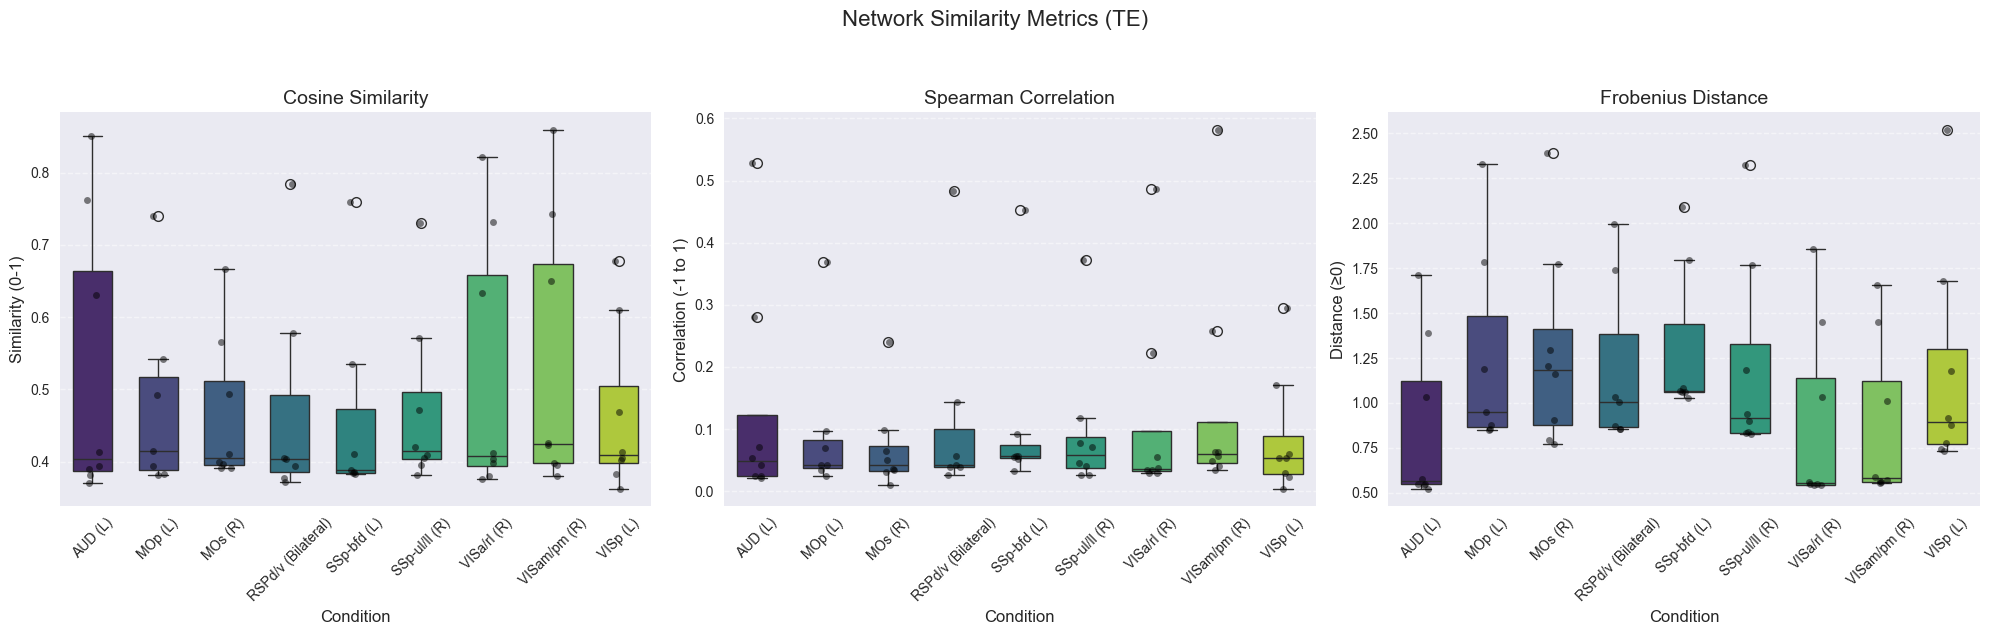

In [6]:
similarity_results, fig = analyze_trial_network_similarity(
    results_folder='results',
    network_type='TE'
)
        
print_similarity_results(similarity_results)

In [7]:
def analyze_pairwise_similarity(data):
    """Calculate pairwise condition similarity"""
    
    # Get all conditions including Rest
    all_conditions = {'Rest': data['rest'], **data['conditions']}
    conditions = list(all_conditions.keys())
    
    results = {c1: {} for c1 in conditions}
    
    for i, cond1 in enumerate(conditions):
        for j, cond2 in enumerate(conditions[i+1:], i+1):
            # Find common sources
            common_sources = set(all_conditions[cond1].keys()) & set(all_conditions[cond2].keys())
            
            # Calculate similarities per source
            cos_vals, sp_vals, frob_vals = [], [], []
            
            for src in common_sources:
                # Get average matrices
                mat1 = np.mean(all_conditions[cond1][src], axis=0)
                mat2 = np.mean(all_conditions[cond2][src], axis=0)
                
                # Calculate similarities
                mask = np.triu_indices_from(mat1, k=1)
                vec1 = mat1[mask]
                vec2 = mat2[mask]
                
                cos_vals.append(1 - cosine(vec1, vec2))
                sp_vals.append(spearmanr(vec1, vec2)[0])
                frob_vals.append(np.linalg.norm(mat1 - mat2, 'fro'))

            # Store results with non-parametric stats
            results[cond1][cond2] = {
                'cosine_similarity': {
                    'median': np.median(cos_vals),
                    'iqr': np.subtract(*np.percentile(cos_vals, [75, 25])),
                    'p_value': mannwhitneyu(cos_vals, np.random.rand(len(cos_vals))).pvalue if len(cos_vals)>1 else 1.0
                },
                'spearman_rho': {
                    'median': np.median(sp_vals),
                    'iqr': np.subtract(*np.percentile(sp_vals, [75, 25])),
                    'p_value': mannwhitneyu(sp_vals, np.random.rand(len(sp_vals))).pvalue if len(sp_vals)>1 else 1.0
                },
                'frobenius_distance': {
                    'median': np.median(frob_vals),
                    'iqr': np.subtract(*np.percentile(frob_vals, [75, 25])),
                    'p_value': mannwhitneyu(frob_vals, np.random.rand(len(frob_vals))).pvalue if len(frob_vals)>1 else 1.0
                },
                'n_sources': len(common_sources)
            }
    
    return results

data = load_network_data(results_folder='results', network_type='TE')
pairwise_results = analyze_pairwise_similarity(data)

In [ ]:
def plot_similarity_heatmap(similarity_data, metric='cosine_similarity', sig_threshold=0.05):
    """
    Plot condition-condition similarity heatmap with improved text visibility
    - White text for dark backgrounds in both lower triangle (similarity) and upper triangle (significance)
    - All other visual elements remain unchanged
    """
    conditions = list(similarity_data.keys())
    n_conds = len(conditions)
    
    # Create similarity matrix
    matrix = np.zeros((n_conds, n_conds))
    for i, cond1 in enumerate(conditions):
        for j, cond2 in enumerate(conditions):
            if i == j: # Diagonal
                if 'distance' in metric.lower():
                    matrix[i, i] = 0.0  # Distance to self is 0
                else:
                    matrix[i, i] = 1.0  # Similarity to self is 1
            elif i < j:
                matrix[i,j] = similarity_data[cond1][cond2][metric]['median']
                matrix[j,i] = matrix[i,j]  # Symmetric
    
    # Collect p-values for FDR correction (if showing significance)
    p_values = []
    for i in range(n_conds):
        for j in range(i+1, n_conds):
            p_values.append(similarity_data[conditions[i]][conditions[j]][metric]['p_value'])
    
    # Perform FDR correction
    from statsmodels.stats.multitest import multipletests
    rejected, pvals_corrected, _, _ = multipletests(p_values, method='fdr_bh')
    
    # Create annotation matrices
    signif_matrix = np.empty((n_conds, n_conds), dtype=object)
    p_idx = 0
    for i in range(n_conds):
        for j in range(n_conds):
            if i == j:
                signif_matrix[i,j] = ""
            elif i < j:
                p_corrected = pvals_corrected[p_idx]
                if p_corrected < 0.001:
                    signif_str = f"{-np.log10(p_corrected):.1f}"
                else:
                    signif_str = f"{-np.log10(p_corrected):.2f}"
                signif_matrix[i,j] = signif_str
                p_idx += 1
    
    # Determine colormaps and ranges
    if "distance" in metric.lower():
        main_cmap = "RdBu_r"  # Blue (low) to Red (high) for distance
        vmin = 0
        vmax = np.percentile(matrix[matrix < 1], 95) if np.any(matrix < 1) else np.max(matrix)
    else:
        main_cmap = "RdBu"  # Blue (low) to Red (high) for similarity
        vmin = 0
        vmax = 1
    
    # Create masks
    mask_upper = np.triu(np.ones_like(matrix, dtype=bool))  # Upper triangle mask
    
    # Plot main heatmap (lower triangle)
    plt.figure(figsize=(7, 5))
    ax = sns.heatmap(
        matrix, 
        annot=False,  # We'll add annotations manually
        fmt=".2f",
        cmap=main_cmap,
        vmin=vmin, 
        vmax=vmax,
        mask=mask_upper,  # Show lower triangle
        linewidths=0,
        linecolor="gray",
        cbar_kws={'label': metric.replace('_', ' ').title()},
        square=True
    )
    
    # Function to determine text color based on background brightness
    def get_text_color(value, cmap, vmin, vmax):
        """Return 'white' for dark backgrounds, 'black' for light"""
        norm = plt.Normalize(vmin, vmax)
        rgb = cmap(norm(value))[:3]  # Get RGB values
        # Calculate perceived brightness (weighted average)
        brightness = 0.299*rgb[0] + 0.587*rgb[1] + 0.114*rgb[2]
        return 'white' if brightness < 0.6 else 'black'
    
    # Add similarity values to lower triangle with adaptive colors
    for i in range(n_conds):
        for j in range(n_conds):
            if i > j:  # Lower triangle
                value = matrix[i,j]
                text_color = get_text_color(value, plt.get_cmap(main_cmap), vmin, vmax)
                ax.text(j+0.5, i+0.5, f"{value:.2f}", 
                       ha='center', va='center', 
                       color=text_color, 
                       fontsize=10,
                       fontweight='bold' if text_color == 'white' else 'normal')
    
    # Create background matrix for significance
    bg_matrix = np.zeros((n_conds, n_conds))
    p_idx = 0
    for i in range(n_conds):
        for j in range(n_conds):
            if i < j:
                p_corrected = pvals_corrected[p_idx]
                if p_corrected < sig_threshold:
                    bg_matrix[i,j] = -np.log10(p_corrected)
                else:
                    bg_matrix[i,j] = -1  # Non-significant
                p_idx += 1
    
    # Normalize significant values
    sig_values = bg_matrix[bg_matrix > 0]
    if len(sig_values) > 0:
        max_sig = np.max(sig_values)
        min_sig = np.min(sig_values)
        bg_matrix[bg_matrix > 0] = (bg_matrix[bg_matrix > 0] - min_sig) / (max_sig - min_sig)
    
    # Plot significance backgrounds and annotations
    bg_cmap = plt.cm.YlOrBr
    for i in range(n_conds):
        for j in range(n_conds):
            if i < j:  # Upper triangle
                if bg_matrix[i,j] == -1:
                    # Non-significant - grey background with black text
                    bg_color = (0.9, 0.9, 0.9)
                    text_color = 'black'
                else:
                    # Significant - colored background
                    bg_color = bg_cmap(bg_matrix[i,j])
                    # Determine text color based on background brightness
                    brightness = 0.299*bg_color[0] + 0.587*bg_color[1] + 0.114*bg_color[2]
                    text_color = 'white' if brightness < 0.6 else 'black'
                
                # Add background
                rect = plt.Rectangle((j, i), 1, 1, fill=True, 
                                    color=bg_color, 
                                    linewidth=0, edgecolor='gray')
                ax.add_patch(rect)
                
                # Add text
                ax.text(j+0.5, i+0.5, signif_matrix[i,j], 
                       ha='center', va='center', 
                       color=text_color, 
                       fontsize=10,
                       fontweight='bold' if text_color == 'white' else 'normal')
    
    # Final formatting
    plt.xticks(np.arange(n_conds)+0.5, conditions, rotation=45, ha="right")
    plt.yticks(np.arange(n_conds)+0.5, conditions, rotation=0)
    # plt.title(f"Condition-Condition {metric.replace('_', ' ').title()}", fontsize=14)
    
    # Add significance colorbar if needed
    if len(sig_values) > 0:
        sm = plt.cm.ScalarMappable(cmap=bg_cmap, 
                                  norm=plt.Normalize(vmin=min_sig, vmax=max_sig))
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax, shrink=0.5, pad=0.02)
        cbar.set_label('-log10(FDR p)')
    
    plt.tight_layout()
    return plt.gcf()

In [ ]:
def hierarchical_clustering_analysis(pairwise_results, metric='frobenius_distance'):
    """
    Perform hierarchical clustering analysis based on network similarity metrics
    
    Args:
        pairwise_results (dict): Dictionary containing pairwise comparison results
        metric (str): Metric to use for clustering ('frobenius_distance' or others)
    
    Returns:
        tuple: (linkage_matrix, dendrogram_figure)
    """
    from scipy.stats import pearsonr
    from scipy.cluster.hierarchy import linkage, dendrogram, cophenet
    from scipy.spatial.distance import squareform
    import numpy as np
    import matplotlib.pyplot as plt

    conditions = list(pairwise_results.keys())
    n_conds = len(conditions)
    
    # Build distance matrix
    dist_matrix = np.zeros((n_conds, n_conds))
    for i, cond1 in enumerate(conditions):
        for j, cond2 in enumerate(conditions):
            if i == j:
                dist_matrix[i, j] = 0
            elif i < j:
                dist_matrix[i, j] = pairwise_results[cond1][cond2][metric]['median']
                dist_matrix[j, i] = dist_matrix[i, j]
    
    # Convert to condensed distance vector
    condensed_dist = squareform(dist_matrix)
    
    # Hierarchical clustering
    Z = linkage(condensed_dist, 'ward')

    # Calculate cophenetic correlation
    cophenetic_dist = cophenet(Z)
    
    # Use the same condensed form for both inputs
    r, _ = pearsonr(condensed_dist, cophenetic_dist)
    print(f"Cophenetic correlation: {r:.2f}")
    
    # Plot dendrogram
    plt.figure(figsize=(5, 4))
    dendrogram(Z, labels=conditions, orientation='top',
               leaf_rotation=90, leaf_font_size=10)
    plt.ylabel('Distance')
    plt.tight_layout()

    plt.savefig("hierarchical_clustering.pdf", bbox_inches='tight', format='pdf')
    plt.show()
    
    return Z, plt.gcf()

In [ ]:
def main_analysis_pipeline():
    data = load_network_data(results_folder='results', network_type='TE')
    
    pairwise_results = analyze_pairwise_similarity(data)
    
    cos_heatmap = plot_similarity_heatmap(pairwise_results, metric='cosine_similarity')
    sp_heatmap = plot_similarity_heatmap(pairwise_results, metric='spearman_rho')
    fb_heatmap = plot_similarity_heatmap(pairwise_results, metric='frobenius_distance')
    
    cluster_linkage, dendro_fig = hierarchical_clustering_analysis(pairwise_results)
    
    return {
        'heatmaps': [cos_heatmap, sp_heatmap, fb_heatmap],
        'supplementary': {
            'clustering': dendro_fig
        }
    }

/var/folders/wc/806vr9fd2b3cbmkr46kx891h0000gn/T/ipykernel_30944/2470269744.py:138: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = plt.Rectangle((j, i), 1, 1, fill=True,
/var/folders/wc/806vr9fd2b3cbmkr46kx891h0000gn/T/ipykernel_30944/2470269744.py:138: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = plt.Rectangle((j, i), 1, 1, fill=True,
/var/folders/wc/806vr9fd2b3cbmkr46kx891h0000gn/T/ipykernel_30944/2470269744.py:138: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = plt.Rectangle((j, i), 1, 1, fill=True,


Cophenetic correlation: 0.72


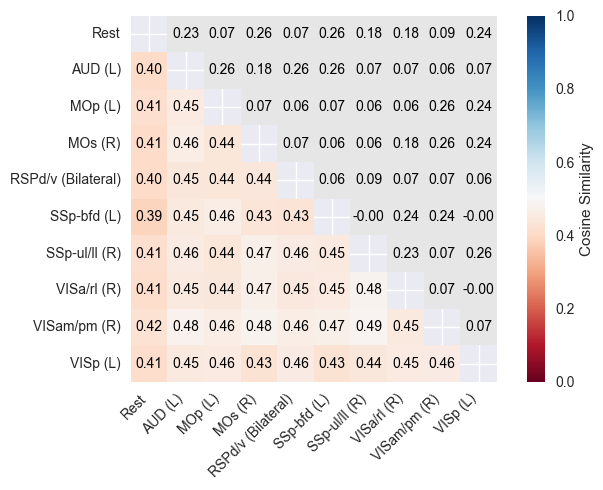

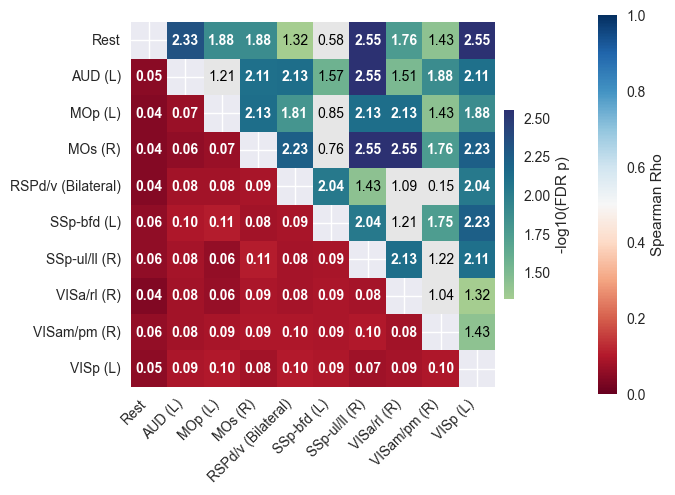

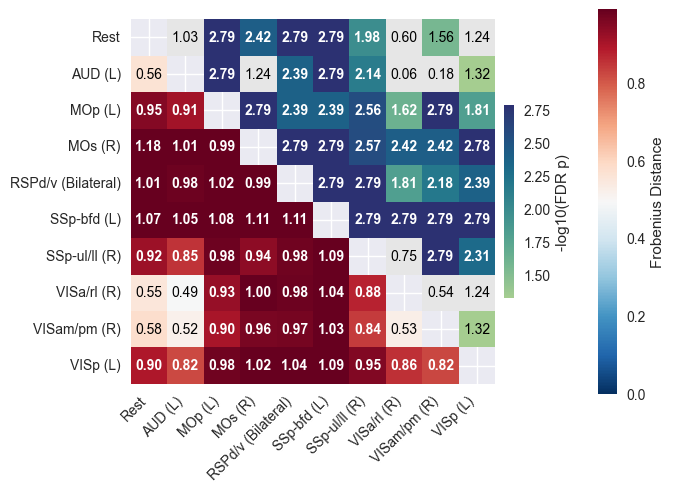

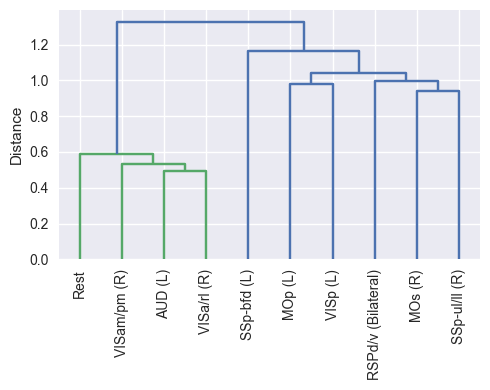

<Figure size 800x550 with 0 Axes>

In [ ]:
analysis_results = main_analysis_pipeline()

for name, fig in zip(['cosine', 'spearman', 'frobenius'], analysis_results['heatmaps']):
    fig.savefig(f"{name}_similarity.pdf", dpi=300, bbox_inches='tight', format='pdf')